In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow.keras as keras    
import gc
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Embedding, Flatten, GaussianNoise
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers.legacy import Adam
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

In [29]:
de_train = pd.read_parquet("/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet")
id_map = pd.read_csv("/kaggle/input/open-problems-single-cell-perturbations/id_map.csv")
sample_submission = pd.read_csv("/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv")

de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [30]:
# Load Data

# Shuffle training data
de_train = de_train.sample(frac=1.0, random_state=42)

# Create features and and labels for reverse model 18211 features and 152 labels for true model
features_columns = ["cell_type", "sm_name"]
labels_columns=["cell_type","sm_name","sm_lincs_id","SMILES","control"]
labels = de_train.drop(columns=labels_columns)
features = pd.DataFrame(de_train, columns=features_columns)

test_data = pd.DataFrame(id_map, columns=features_columns)
features

,cell_type,sm_name
350,T regulatory cells,TPCA-1
377,NK cells,Dovitinib
163,T regulatory cells,Tacalcitol
609,T regulatory cells,Atorvastatin
132,T cells CD8+,MK-5108
...,...,...
71,T regulatory cells,Raloxifene
106,NK cells,Dabrafenib
270,T regulatory cells,RN-486
435,NK cells,Doxorubicin


In [31]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the encoder
encoder = OneHotEncoder()

# Fit the encoder on features
encoder.fit(features)

# Transform the features into one-hot encoded format
one_hot_encode_features = encoder.transform(features)

# Transform the test data(id_map)
one_hot_test = encoder.transform(test_data)

In [32]:
one_hot_encode_features.toarray().shape, one_hot_test.toarray().shape
one_hot_encode_features.toarray()[0].shape

(152,)

In [33]:
from sklearn.metrics import mean_absolute_error

def calculate_mae_and_mrrmse(model, data, y_true):
    """
    Calculate Mean Absolute Error (MAE) and Mean Rowwise Root Mean Squared Error (MRRMSE).

    Parameters:
    - model: The trained  model.
    - data: The input data for prediction.
    - y_true: The true target values.
    - scaler: The scaler used for data normalization.

    Returns:
    - None
    """
    # Predict using the model
    y_pred_original = model.predict(data, batch_size=1)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true , y_pred_original)
    
    # Calculate Mean Rowwise Root Mean Squared Error (MRRMSE)
    rowwise_rmse = np.sqrt(np.mean(np.square(y_true - y_pred_original), axis=1))
    mrrmse_score = np.mean(rowwise_rmse)
    
    # Print the results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Rowwise Root Mean Squared Error (MRRMSE): {mrrmse_score}")
def mean_rowwise_rmse_loss(y_true, y_pred):
    """
    Custom loss function to calculate the Mean Rowwise Root Mean Squared Error (RMSE) loss.

    Parameters:
    - y_true: The true target values.
    - y_pred: The predicted values.

    Returns:
    - Mean Rowwise RMSE loss as a scalar tensor.
    """
    # Calculate RMSE for each row
    rmse_per_row = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    # Calculate the mean of RMSE values across all rows
    mean_rmse = tf.reduce_mean(rmse_per_row)
    
    return mean_rmse
def custom_mean_rowwise_rmse(y_true, y_pred):
    """
    Custom metric to calculate the Mean Rowwise Root Mean Squared Error (RMSE).

    Parameters:
    - y_true: The true target values.
    - y_pred: The predicted values.

    Returns:
    - Mean Rowwise RMSE as a scalar tensor.
    """
    # Calculate RMSE for each row
    rmse_per_row = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    # Calculate the mean of RMSE values across all rows
    mean_rmse = tf.reduce_mean(rmse_per_row)
    
    return mean_rmse

In [34]:
full_features = one_hot_encode_features.toarray()
full_labels = labels.values
full_features.shape

(614, 152)

In [35]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
print(full_features.shape)

(614, 152)


In [36]:
# non-ensembled baseline
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LSTM

tf.random.set_seed(42)

model_2 = Sequential([
    Dense(4096, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(2048, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1024, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(18211, activation="linear")
])

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0025)

model_2.compile(loss="mae", 
                optimizer=custom_optimizer,
                metrics=[custom_mean_rowwise_rmse])

history_2 = model_2.fit(full_features, full_labels,
                       epochs=80,
                       verbose=0)

preds = model_2.predict(one_hot_test.toarray(), batch_size=1)

preds.shape

sample_columns = sample_submission.columns
sample_columns= sample_columns[1:]
submission_df = pd.DataFrame(preds, columns=sample_columns)
submission_df.insert(0, 'id', range(255))
submission_df.to_csv("submission_df.csv", index=False)
!zip submission_preds.zip /kaggle/working/submission_df.csv

submission_df

255/255 [==============================] - 1s 2ms/step
  adding: kaggle/working/submission_df.csv (deflated 58%)


,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,-0.093057,-0.063798,0.246579,0.850947,0.609188,0.096213,0.097469,0.052079,-0.675050,...,-0.700769,0.077390,-0.058569,0.030816,-0.145131,0.159202,0.459922,0.697631,-0.648664,0.145639
1,1,0.091111,-0.001346,0.341300,0.177157,0.459733,0.370077,0.079672,0.258147,0.085496,...,0.066526,0.059940,-0.036974,0.303070,0.267644,0.110969,0.112718,0.124321,-0.162662,-0.184164
2,2,0.512939,0.211456,-0.139261,0.196991,0.838540,1.287130,0.258435,0.541751,0.067214,...,-0.076440,0.109478,-0.219793,0.316763,0.375068,0.183607,0.299450,0.451190,-0.197420,-0.181802
3,3,0.080399,0.157192,0.168775,0.377740,-0.028720,-0.088567,-0.109618,0.129603,-0.057643,...,-0.247559,0.040040,0.035532,0.142601,0.137184,0.141681,0.012904,0.252152,-0.168371,-0.188828
4,4,0.157029,0.025125,0.210681,0.366742,0.381705,0.229305,0.066676,0.237584,-0.008521,...,-0.522882,0.131060,-0.088700,0.190602,-0.014256,0.153835,0.249571,0.500471,-0.199861,0.150751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,0.053101,-0.183511,0.135198,-0.541617,1.389904,0.268759,0.350837,-0.015060,-0.008005,...,-0.207615,-0.688212,-0.331153,-0.921953,0.260877,-0.659264,-0.401775,-0.232143,-0.724899,0.061352
251,251,0.153067,-0.220522,0.128518,-0.101720,1.494322,0.632019,0.316073,0.265190,0.228242,...,-0.070557,-0.477777,-0.315142,-0.703098,0.267245,-0.487079,-0.285317,0.021741,-0.784596,0.032260
252,252,0.099981,0.035385,0.475276,0.017456,1.211654,-0.004797,0.149932,-0.005177,0.005228,...,-0.251077,-0.224622,-0.128021,-0.209260,0.135555,-0.324998,-0.175909,0.090266,-0.292683,0.063092
253,253,1.222807,0.027162,-0.726786,1.927711,6.925933,2.822092,0.826996,0.239890,0.746266,...,-0.583951,-0.404101,-1.271796,-1.960484,1.542713,-0.951882,-0.551244,0.182702,-0.613035,0.054969


In [37]:
# final model, ensembled
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def create_model(seed):
    tf.random.set_seed(seed)
    model = Sequential([
        Dense(4096, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(2028, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1028, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(18211, activation="linear")
    ])
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0025)
    model.compile(loss="mae", optimizer=custom_optimizer, metrics=[custom_mean_rowwise_rmse])
    return model

num_models = 10
ensemble_models = []

for i in tqdm(range(num_models)):
    model = create_model(seed=i)
    history = model.fit(full_features, full_labels, epochs=80, verbose=0)
    ensemble_models.append(model)

def predict_ensemble(models, data):
    predictions = [model.predict(data, batch_size=1) for model in models]
    return np.mean(predictions, axis=0)

ensemble_test_preds = predict_ensemble(ensemble_models, one_hot_test.toarray())

sample_columns = sample_submission.columns
sample_columns= sample_columns[1:]
ensemble_submission_df = pd.DataFrame(ensemble_test_preds, columns=sample_columns)
ensemble_submission_df.insert(0, 'id', range(len(ensemble_submission_df)))

ensemble_submission_df.to_csv("ensemble_submission_df.csv", index=False)
!zip ensemble_submission_preds.zip /kaggle/working/ensemble_submission_df.csv
ensemble_submission_df

 60%|██████    | 6/10 [01:26<00:57, 14.45s/it]


KeyboardInterrupt: 

In [39]:
import optuna
# Optuna optimization
def objective(trial):
    num_layers = trial.suggest_int('num_layers', 2, 5)
    num_units = trial.suggest_int('num_units', 512, 4096)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    model = Sequential()
    for _ in range(num_layers):
        model.add(Dense(num_units, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(18211, activation="linear"))

    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mae", optimizer=custom_optimizer, metrics=[custom_mean_rowwise_rmse])

    model.fit(full_features, full_labels, epochs=80, verbose=0)

    val_preds = model.predict(validation_features, batch_size=1)
    mae = mean_absolute_error(validation_labels, val_preds)

    return mae

full_features, validation_features, full_labels, validation_labels = train_test_split(
    full_features, full_labels, test_size=0.2, random_state=42
)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-12-20 05:15:00,981] A new study created in memory with name: no-name-9832d0f6-4134-494b-843e-f94b6e4c15f1


99/99 [==============================] - 0s 1ms/step


[I 2023-12-20 05:15:12,169] Trial 0 finished with value: 0.898200694529294 and parameters: {'num_layers': 3, 'num_units': 1742, 'dropout_rate': 0.21787811128393386, 'learning_rate': 0.0005498926457004796}. Best is trial 0 with value: 0.898200694529294.
[W 2023-12-20 05:15:15,451] Trial 1 failed with parameters: {'num_layers': 3, 'num_units': 822, 'dropout_rate': 0.2014324893712568, 'learning_rate': 0.006332074294831869} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_42/2498240740.py", line 19, in objective
    model.fit(full_features, full_labels, epochs=80, verbose=0)
  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 

KeyboardInterrupt: 

## Generating Charts

In [15]:
from sklearn.decomposition import PCA
import pandas as pd

de_train = pd.read_parquet("/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet")
id_map = pd.read_csv("/kaggle/input/open-problems-single-cell-perturbations/id_map.csv")
sample_submission = pd.read_csv("/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv")

# Shuffle training data
de_train = de_train.sample(frac=1.0, random_state=42)

cell_type = de_train["cell_type"]
sm_name = de_train["sm_name"]

labels_columns=["cell_type","sm_name","sm_lincs_id","SMILES","control"]
labels = de_train.drop(columns=labels_columns)

n_components = 3

pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(labels)

features = pd.DataFrame(data=principalComponents, columns=[f'principal component {i + 1}' for i in range(n_components)])

features["cell_type"] = cell_type
features["sm_name"] = sm_name

explained_variance_ratio = sum(pca.explained_variance_ratio_)
print(f"Total explained variance: {round(explained_variance_ratio * 100, 2)}%")

features

Total explained variance: 75.0%


,principal component 1,principal component 2,principal component 3,cell_type,sm_name
0,189.308570,-20.668613,-4.741304,NK cells,Clotrimazole
1,-85.972517,-8.987888,-6.151517,T cells CD4+,Clotrimazole
2,14.178192,-15.899425,-8.674569,T cells CD8+,Clotrimazole
3,-118.674501,-10.008553,-17.696765,T regulatory cells,Clotrimazole
4,-39.920115,-18.694989,-8.638507,NK cells,Mometasone Furoate
...,...,...,...,...,...
609,90.479087,-17.921154,-1.369219,T regulatory cells,Atorvastatin
610,66.427022,-17.367856,0.818837,NK cells,Riociguat
611,-64.708869,-12.603492,-8.738162,T cells CD4+,Riociguat
612,11.738114,-6.535858,13.382031,T cells CD8+,Riociguat


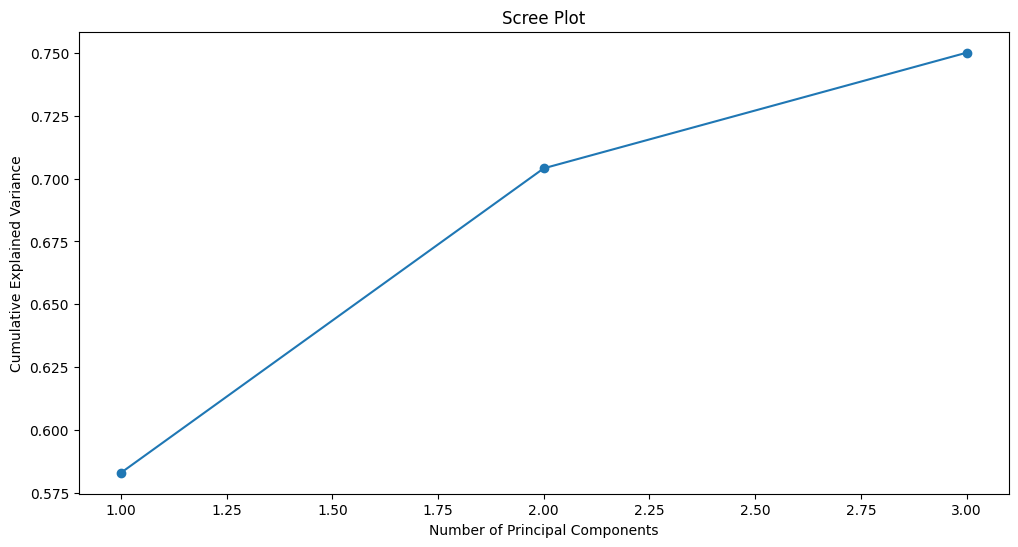

In [18]:
# when analyzing all 64 PC's
import numpy as np
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

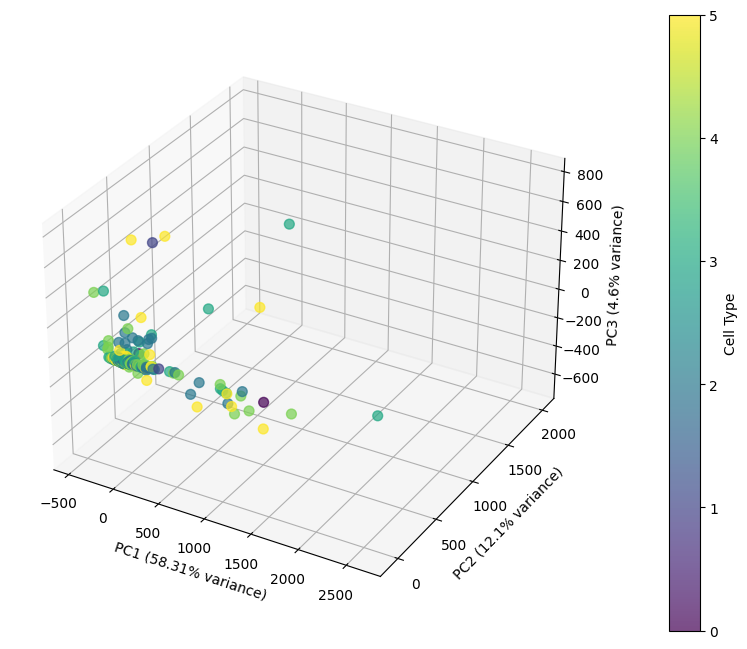

In [20]:
# when n_component = 3
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    features['principal component 1'], 
    features['principal component 2'], 
    features['principal component 3'], 
    c=features['cell_type'].astype('category').cat.codes,  # Color by cell type
    cmap='viridis', 
    s=50, 
    alpha=0.7
)

ax.set_xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0] * 100, 2)}% variance)')
ax.set_ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1] * 100, 2)}% variance)')
ax.set_zlabel(f'PC3 ({round(pca.explained_variance_ratio_[2] * 100, 2)}% variance)')

colorbar = fig.colorbar(scatter, ax=ax, pad=0.1)
colorbar.set_label('Cell Type')

plt.show()

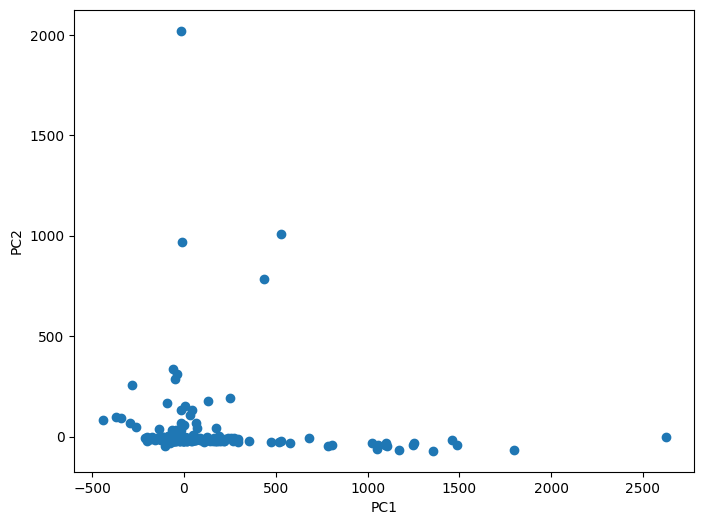

In [23]:
# when n_components = 2
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(features['principal component 1'], features['principal component 2'])
plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.show()

In [25]:
# generate loss chart
plt.figure(figsize=(12, 6))

for i, history in enumerate(histories):
    train_loss = np.array(history.history['loss'])
    train_loss_smooth = np.convolve(train_loss, np.ones(10)/10, mode='valid')
    plt.plot(train_loss_smooth, label=f'Model {i + 1} Training Loss', linestyle='-', color=f'C{i}')
    
    val_loss = np.array(history.history['val_loss'])
    val_loss_smooth = np.convolve(val_loss, np.ones(10)/10, mode='valid')
    plt.plot(val_loss_smooth, label=f'Model {i + 1} Validation Loss', linestyle='--', color=f'C{i}')

plt.title('Training and Validation Loss Over Time for Each Model')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

NameError: name 'histories' is not defined

<Figure size 1200x600 with 0 Axes>